# Importing required modules

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [5]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [6]:
# read in an edge list from the file 'test.txt'
G = nx.read_edgelist('./edges.txt', comments='#',
                     create_using=nx.DiGraph(), 
                     delimiter=' ', 
                     nodetype=int, 
                     encoding='utf-8')
nx.info(G)

'DiGraph with 435 nodes and 1528 edges'

## **Before Randomization**

In [7]:
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

In [8]:
print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

# print()
# print("the adjacency list")
# for line in nx.generate_adjlist(G):
#     print(line)

Number of nodes:  435
Number of edges:  1528

Average degree:  7.025287356321839
Average degree (alternate calculation) 7.025287356321839

Minimum degree:  1
Maximum degree:  32


In [9]:
# Calculate Average Shortest Path Length and the standard deviation

# Calculate all shortest paths for all connected nodes in the graph first
spDict = dict(nx.all_pairs_shortest_path_length(G))

# Iterate through every node and average their shortest paths and store it into a new dict
avgSPDict = {}

nodes = sorted(list(spDict.keys()))
# Remove the entry that has 0 as a source. Not sure why that is there at all
nodes.remove(0)

# Calculate average sp length for each node that has connections
for node in nodes:
    connectedNodes = list(spDict[node].keys())
    sourceNode = node
    avgSPLength = 0

    # The first entry in connectedNodes is always the source, as the function checks for loops
    # If the connectedNodes for that node is not greater than 1 then there are no other connections

    # Calculate avg shortest path length for nodes with connections
    if len(connectedNodes) > 1:
        for cNode in connectedNodes:
            if sourceNode != cNode:
                avgSPLength += spDict[node][cNode]

        # Find the average of all shortest paths for this node
        avgSPLength = (avgSPLength / (len(connectedNodes) - 1))

        # Update avgSPDict
        avgSPDict[node] = avgSPLength

# Calculate standard deviation of avg shortest paths in the network
# Logic found here : https://www.geeksforgeeks.org/calculate-standard-deviation-of-a-dictionary-in-python/
avgSPList = []
for avgSP in avgSPDict.values():
    avgSPList.append(avgSP)

avgSP = np.average(avgSPList)
print(f'The average shortest path length for our graph is {avgSP}')
avgSPSD = np.std(avgSPList)
print(f'The standard deviation for the average shortest paths in our network is {avgSPSD}')

The average shortest path length for our graph is 4.656888389155912
The standard deviation for the average shortest paths in our network is 3.456618753998504


In [10]:
# Calculate the clustering coefficient of our graph and the standard deviation

# Calculate cc for each node
ccDict = nx.clustering(G)

# Calculate average cc for the graph
cc = nx.average_clustering(G)
print(f'The average clustering coeffcicient for our directed graph is {cc}')

# Calculate the standard deviation using all the nodes' clustering coefficients
ccList = list(ccDict.values())
ccSD = np.std(ccList)
print(f'The standard deviation for the clustering coefficients in the graph is {ccSD}')



The average clustering coeffcicient for our directed graph is 0.25810113720293165
The standard deviation for the clustering coefficients in the graph is 0.24814703382859649


Degree Distribution - Before Randomization

In [11]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


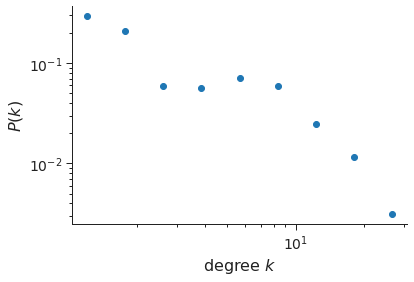

In [12]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

Network - Before Randomization

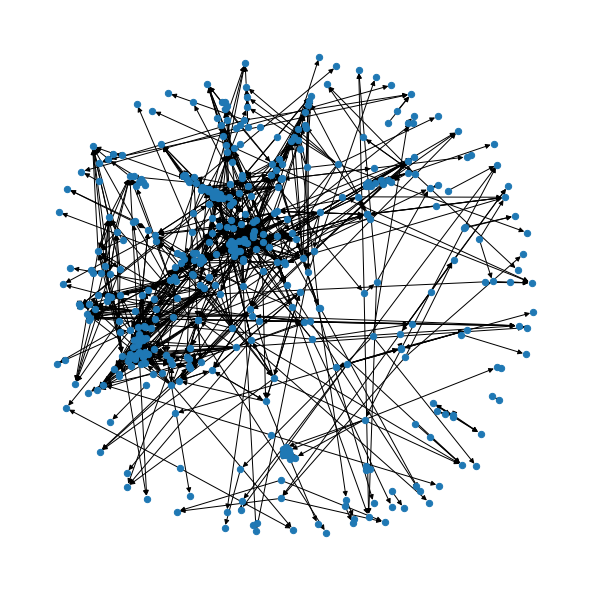

In [13]:
# using the force-based or "spring" layout algorithm
fig = plt.figure(figsize=(8,8))
nx.draw_spring(G, node_size=40)

## **After Randomization**

Create a Random Network using a Configuration Model

In [14]:
inDeg = list(g for N, g in G.in_degree())
outDeg = list(g for N, g in G.out_degree())
R_G = nx.directed_configuration_model(inDeg, outDeg, create_using=G)

R_N = len(G)
R_L = G.size()
R_degrees = [G.degree(node) for node in G]
R_kmin = min(degrees)
R_kmax = max(degrees)
# print()
# print("the adjacency list")
# for line in nx.generate_adjlist(G):
#     print(line)

Create an ensemble of 1000 Random Networks

In [15]:
NUM_RANDOM_NETWORKS = 1000
avgCCList = []
avgShortestPList = []
avgCCStdList = []
avgPathStdList = []


for _ in range(NUM_RANDOM_NETWORKS):
    # Create a random network using directed_configuration_model
    # This returns a directed Graph that maintains the in degree and out degrees for the nodes
    newR_G = nx.directed_configuration_model(inDeg, outDeg,create_using=G)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Calculate the clustering coefficient of our graph and find the standard deviation

    # Calculate cc for each node
    ccDict = nx.clustering(newR_G)

    # Calculate average cc for the graph and append to our average cc list
    cc = nx.average_clustering(newR_G)
    avgCCList.append(cc)
    # print(f'The average clustering coeffcicient for our directed graph is {cc}')

    # Calculate the standard deviation using all the nodes' clustering coefficients
    ccList = list(ccDict.values())
    ccSD = np.std(ccList)
    # print(f'The standard deviation for the clustering coefficients in the graph is {ccSD}')

    # Append the standard deviation of the clustering coefficient in the network
    avgCCStdList.append(ccSD)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Average shortest path length of the current network
    # Calculate average shortest path for all connected nodes in the graph

    # Calculate all shortest paths for all connected nodes in the graph first
    spDict = dict(nx.all_pairs_shortest_path_length(newR_G))

    # Iterate through every node and average their shortest paths and store it into a new dict
    avgSPDict = {}

    nodes = sorted(list(spDict.keys()))
    # Remove the entry that has 0 as a source. Not sure why that is there at all
    nodes.remove(0)

    # Calculate average sp length for each node that has connections
    for node in nodes:
        connectedNodes = list(spDict[node].keys())
        avgSPLength = 0

        # The first entry in connectedNodes is always the source, as the function checks for loops
        # If the connectedNodes for that node is not greater than 1 then there are no other connections

        # Calculate avg shortest path length for nodes with connections
        if len(connectedNodes) > 1:
            for cNode in connectedNodes:
                if node != cNode:
                    avgSPLength += spDict[node][cNode]

            # Find the average of all shortest paths for this node
            # We subtract 1 to account of the entry that checks if the source node has a conenction to itself
            avgSPLength = (avgSPLength / (len(connectedNodes) - 1))

            # Update avgSPDict
            avgSPDict[node] = avgSPLength
    
    # Calculate and update the average shortest paths in the network
    avgSPList = list(avgSPDict.values())
    avgSP = np.average(avgSPList)
    avgShortestPList.append(avgSP)

    # Calculate standard deviation of avg shortest paths in the network
    avgSPSD = np.std(avgSPList)
    # print(f'The standard deviation for the average shortest paths in the random network is {avgSPSD}')
    avgPathStdList.append(avgSPSD)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

avgCCOverall = np.average(avgCCList)
avgSPOverall = np.average(avgShortestPList)
pathStd = np.average(avgPathStdList)
ccStd = np.average(avgCCStdList)

print(f'The average clustering coefficient over {NUM_RANDOM_NETWORKS} randomly generated networks is {avgCCOverall}')
print(f'The average standard deviation over {NUM_RANDOM_NETWORKS} randomly generated networks average clustering coefficient standard deviation is {ccStd}')

print(f'The average shortest path length over {NUM_RANDOM_NETWORKS} randomly generated networks is {avgSPOverall}')
print(f'The average standard deviation over {NUM_RANDOM_NETWORKS} randomly generated networks average shortest path standard deviation is {pathStd}')


The average clustering coefficient over 1000 randomly generated networks is 0.016201069053873692
The average standard deviation over 1000 randomly generated networks average clustering coefficient is standard deviation is 0.043208610449567975
The average shortest path length over 1000 randomly generated networks is 4.442141464085197
The average standard deviation over 1000 randomly generated networks average shortest path standard deviation is 0.9071040766192078


Degree Distribution - After Randomization

In [16]:
# Get 10 logarithmically spaced bins between kmin and kmax
R_bin_edges = np.logspace(np.log10(R_kmin), np.log10(R_kmax), num=10)

# histogram the data into these bins
R_density, _ = np.histogram(R_degrees, bins=bin_edges, density=True)

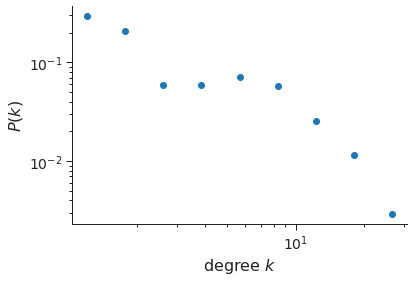

In [17]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(R_bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, R_density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

Network - After Randomization

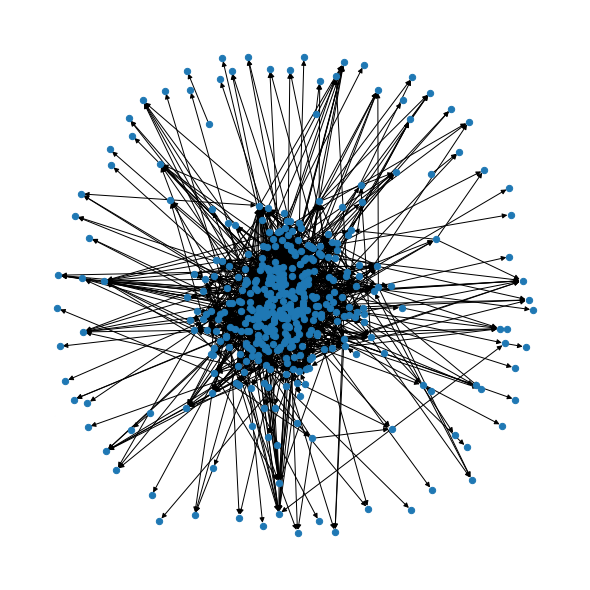

In [18]:
# using the force-based or "spring" layout algorithm
fig = plt.figure(figsize=(8,8))
R_G.remove_edges_from(nx.selfloop_edges(R_G))
nx.draw_spring(R_G, node_size=40)

## Closeness and Betweenness Centrality


In [25]:
# Real Network Centralities
# print("Closeness Centrality for Real Network ", np.average(list(nx.closeness_centrality(G).values())))
closenessReal = nx.closeness_centrality(G)
print(np.average(list(closenessReal.values())))

betweennessReal = nx.betweenness_centrality(G)
print(np.average(list(betweennessReal.values())))
# print("Betweenness Centrality for Real Network ", nx.betweenness_centrality(G))

closenessRealRG = nx.closeness_centrality(R_G)
print(np.average(list(closenessRealRG.values())))

betweennessRealRG = nx.betweenness_centrality(R_G)
print(np.average(list(betweennessRealRG.values())))

# Change graphs used for random network
# print("Closeness Centrality for Random Network ", nx.closeness_centrality(R_G))
# print("Betweenness Centrality for Random Network ", nx.betweenness_centrality(R_G))

0.13717495786016504
0.004932567400487877
0.13717495786016504
0.004932567400487877
